In [1]:
import os
from defillama2 import DefiLlama
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, FuncFormatter

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use("fivethirtyeight")

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
# set paths and create dirs 
base_dir = '../'
png_dir = os.path.join(base_dir, 'png')
os.makedirs(png_dir, exist_ok=True)

In [3]:
def human_format_dollar_or_num(dollar=False, decimals=0):
    """ 
    Return a function for formatting matplot axis numbers human friendly. 

    Parameters
    ----------
    dollar : logical
        If True, will add $ in front of the numbers.
    decimals : int
        Number of decimals to display.
    """

    base_fmt = '%.{}f%s'.format(decimals)
    if dollar:
        base_fmt = '$' + base_fmt

    def human_format(num, pos): # pos is necessary as it'll be used by matplotlib
        magnitude = 0
        while abs(num) >= 1000:
            magnitude += 1
            num /= 1000.0
        return base_fmt % (num, ['', 'K', 'M', 'B', 'T', 'P'][magnitude])
    return human_format

def plot_tvl_apy(df, tvl_col='tvlUsd', apy_col='apy', title=None):
    # plot TVL and APY over time to see their relationships. 
    
    # plot TVL on the left y-axis
    ax1 = df[tvl_col].plot()
    dollar_formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
    ax1.yaxis.set_major_formatter(dollar_formatter)
    for tl in ax1.get_yticklabels():
        tl.set_color('#008FD5')
    ax1.set_ylabel('TVL ($USD)', color='#008FD5')

    # plot APY on the right y-axis
    ax2 = ax1.twinx()
    ax2.plot(df.index, df[apy_col], color='#77AB43')
    ax2.yaxis.set_major_formatter(PercentFormatter(decimals=2))
    for tl in ax2.get_yticklabels():
        tl.set_color('#77AB43')
    ax2.set_ylabel('APY', color='#77AB43')

    plt.title(title)
    plt.tight_layout()

## Get current APYs and TVLs

There are two major UniV3 WMATIC-USDC pools:

- [0.3%  fee](https://info.uniswap.org/#/polygon/pools/0x88f3c15523544835ff6c738ddb30995339ad57d6)
- [0.05% fee](https://info.uniswap.org/#/polygon/pools/0xa374094527e1673a86de625aa59517c5de346d32)

In [4]:
obj = DefiLlama()

In [5]:
df = obj.get_pools_yields()

In [6]:
is_true = (
    df.chain.isin(['Polygon']) &
    df.project.isin(['uniswap-v3']) &
    df.symbol.isin(['WMATIC-USDC']) 
)
cols = ['chain', 'symbol', 'pool', 'tvlUsd', 'apy', 'apyPct7D', 
        'mu', 'sigma', 'count', 'predictedClass', 'predictedProbability']
subdf = df.loc[is_true, cols].sort_values('apy', ascending=False)
subdf.head()

,chain,symbol,pool,tvlUsd,apy,apyPct7D,mu,sigma,count,predictedClass,predictedProbability
557,Polygon,WMATIC-USDC,6dfaa280-b16e-4a49-bd12-175082979153,6777910,81.7365,59.2161,53.3686,1.3450,293,Down,81.0000
2076,Polygon,WMATIC-USDC,423a7321-1249-4eca-af64-a5b5803a1247,766694,66.4530,41.4652,35.5447,1.2709,293,Down,82.0000
7438,Polygon,WMATIC-USDC,da47db29-8407-4921-ab5a-4753b7aede4d,33459,12.5183,-21.7167,20.7953,1.3052,293,Down,51.0000


In [7]:
# tell which pool charges 0.05%, 0.3% or 1% fees
conds = [(subdf.pool == '6dfaa280-b16e-4a49-bd12-175082979153'),
         (subdf.pool == '423a7321-1249-4eca-af64-a5b5803a1247'),
         (subdf.pool == 'da47db29-8407-4921-ab5a-4753b7aede4d')]
choices = ['0.05%', '0.3%', '1%']
subdf['pool_fee'] = np.select(conds, choices)
cols = ['chain', 'symbol', 'pool', 'pool_fee', 'tvlUsd', 'apy', 'apyPct7D', 
        'mu', 'sigma', 'count', 'predictedClass', 'predictedProbability']
subdf[cols]

,chain,symbol,pool,pool_fee,tvlUsd,apy,apyPct7D,mu,sigma,count,predictedClass,predictedProbability
557,Polygon,WMATIC-USDC,6dfaa280-b16e-4a49-bd12-175082979153,0.05%,6777910,81.7365,59.2161,53.3686,1.3450,293,Down,81.0000
2076,Polygon,WMATIC-USDC,423a7321-1249-4eca-af64-a5b5803a1247,0.3%,766694,66.4530,41.4652,35.5447,1.2709,293,Down,82.0000
7438,Polygon,WMATIC-USDC,da47db29-8407-4921-ab5a-4753b7aede4d,1%,33459,12.5183,-21.7167,20.7953,1.3052,293,Down,51.0000


Observations:

- The TVL of 5bp-pool is 8.8 times of 30bp-pool.
- The APY of 5bp-pool is 15%+ higher than 30bp-pool. DefiLlama predicts the APYs of both pools to drop. 
- Historically, over 293 days, the average APY for 5bp-pool is 53.4% with a 1.3% volatility; the average APY for 30bp-pool is 35.5% with a 1.27% volatility.
- Looks like 5bp-pool is better.

## Get historical APYs and TVLs

In [8]:
pool_005_id = '6dfaa280-b16e-4a49-bd12-175082979153'
pool_03_id  = '423a7321-1249-4eca-af64-a5b5803a1247'

In [14]:
df005 = obj.get_pool_hist_apy(pool_005_id).loc[:,['tvlUsd', 'apy']]
df03  = obj.get_pool_hist_apy(pool_03_id).loc[:,['tvlUsd', 'apy']]

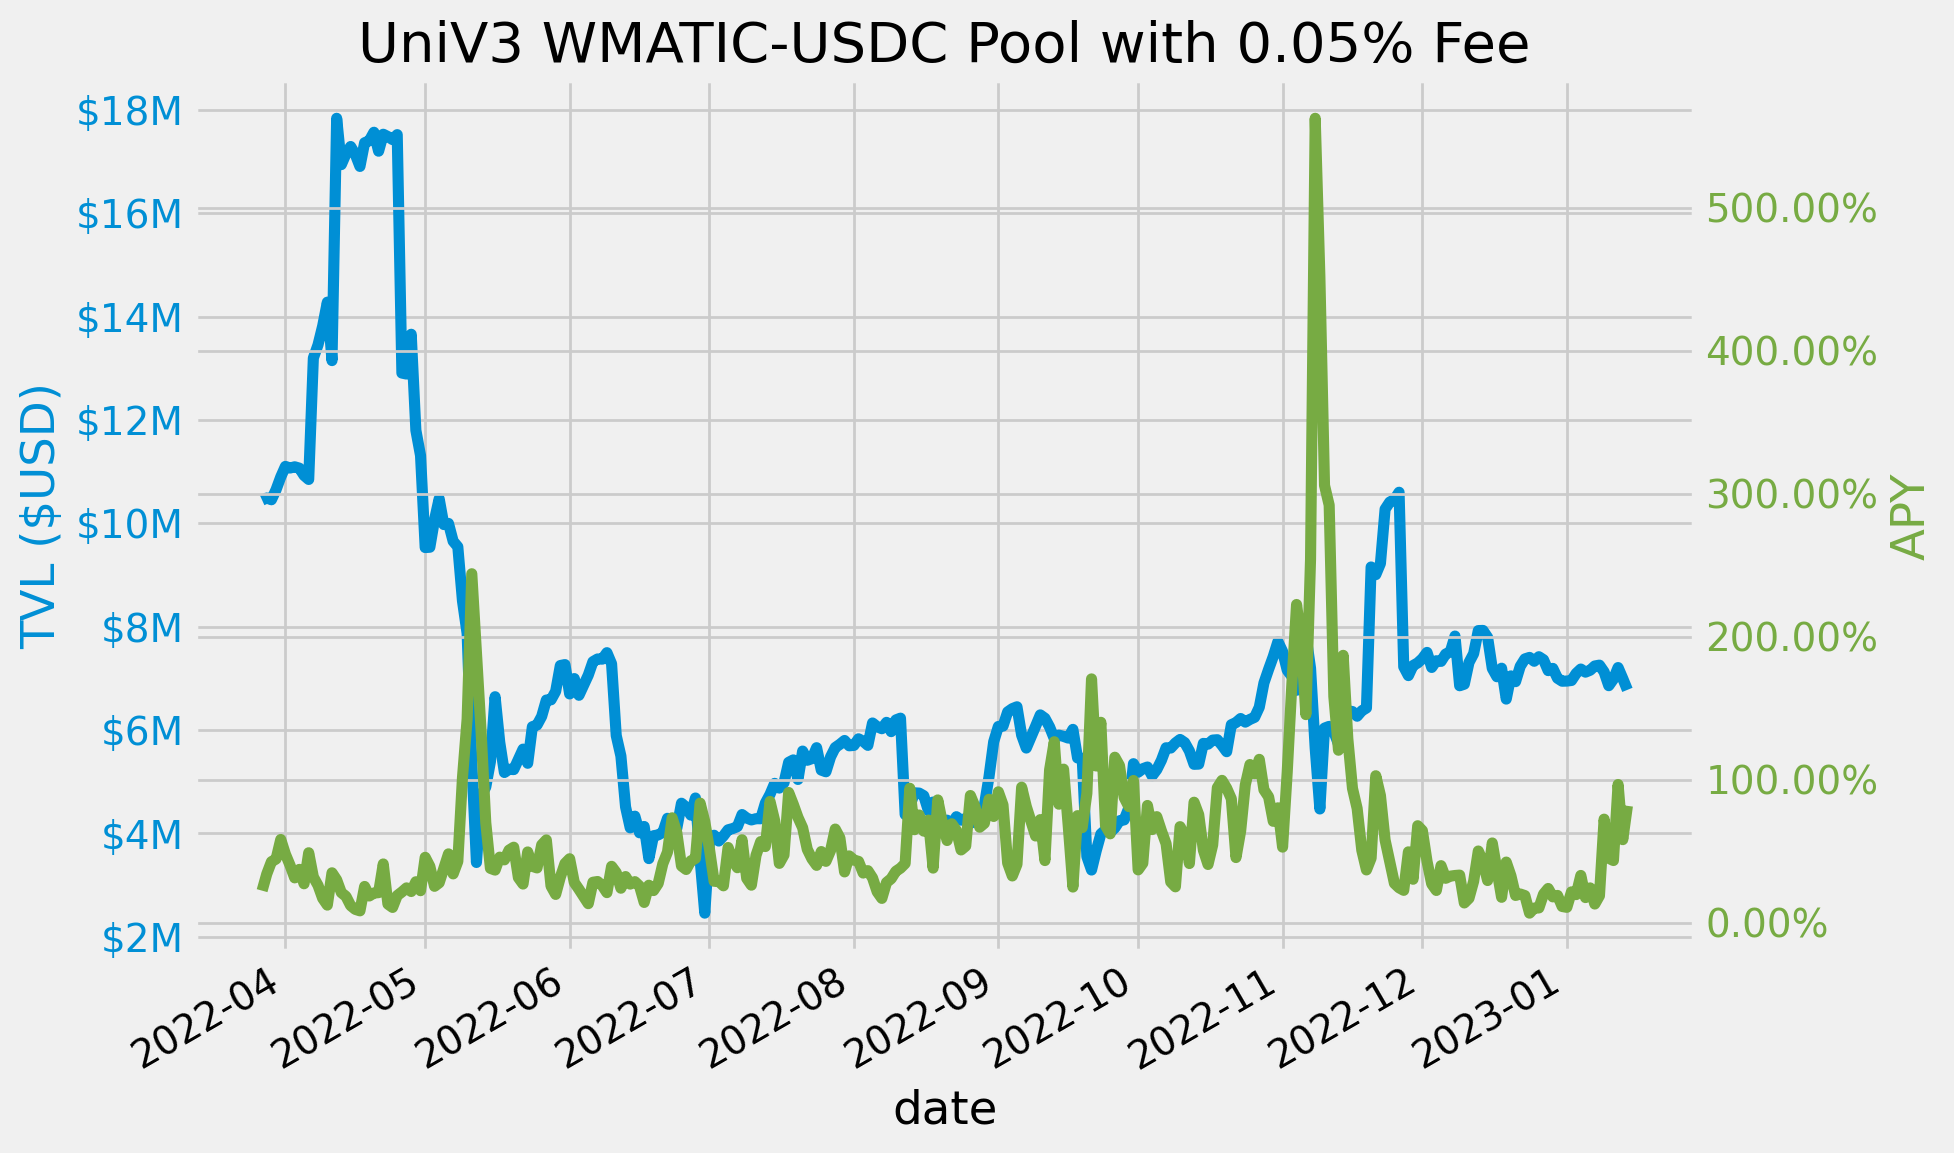

In [15]:
plot_tvl_apy(df005, title='UniV3 WMATIC-USDC Pool with 0.05% Fee')
plt.savefig(os.path.join(png_dir, 'UniV3 WMATIC-USDC Pool with 0.05% Fee.png'), dpi=300)

The TVL of 5bp-pool has been going sideways since Dec 2022 and the yield is on the rise. 

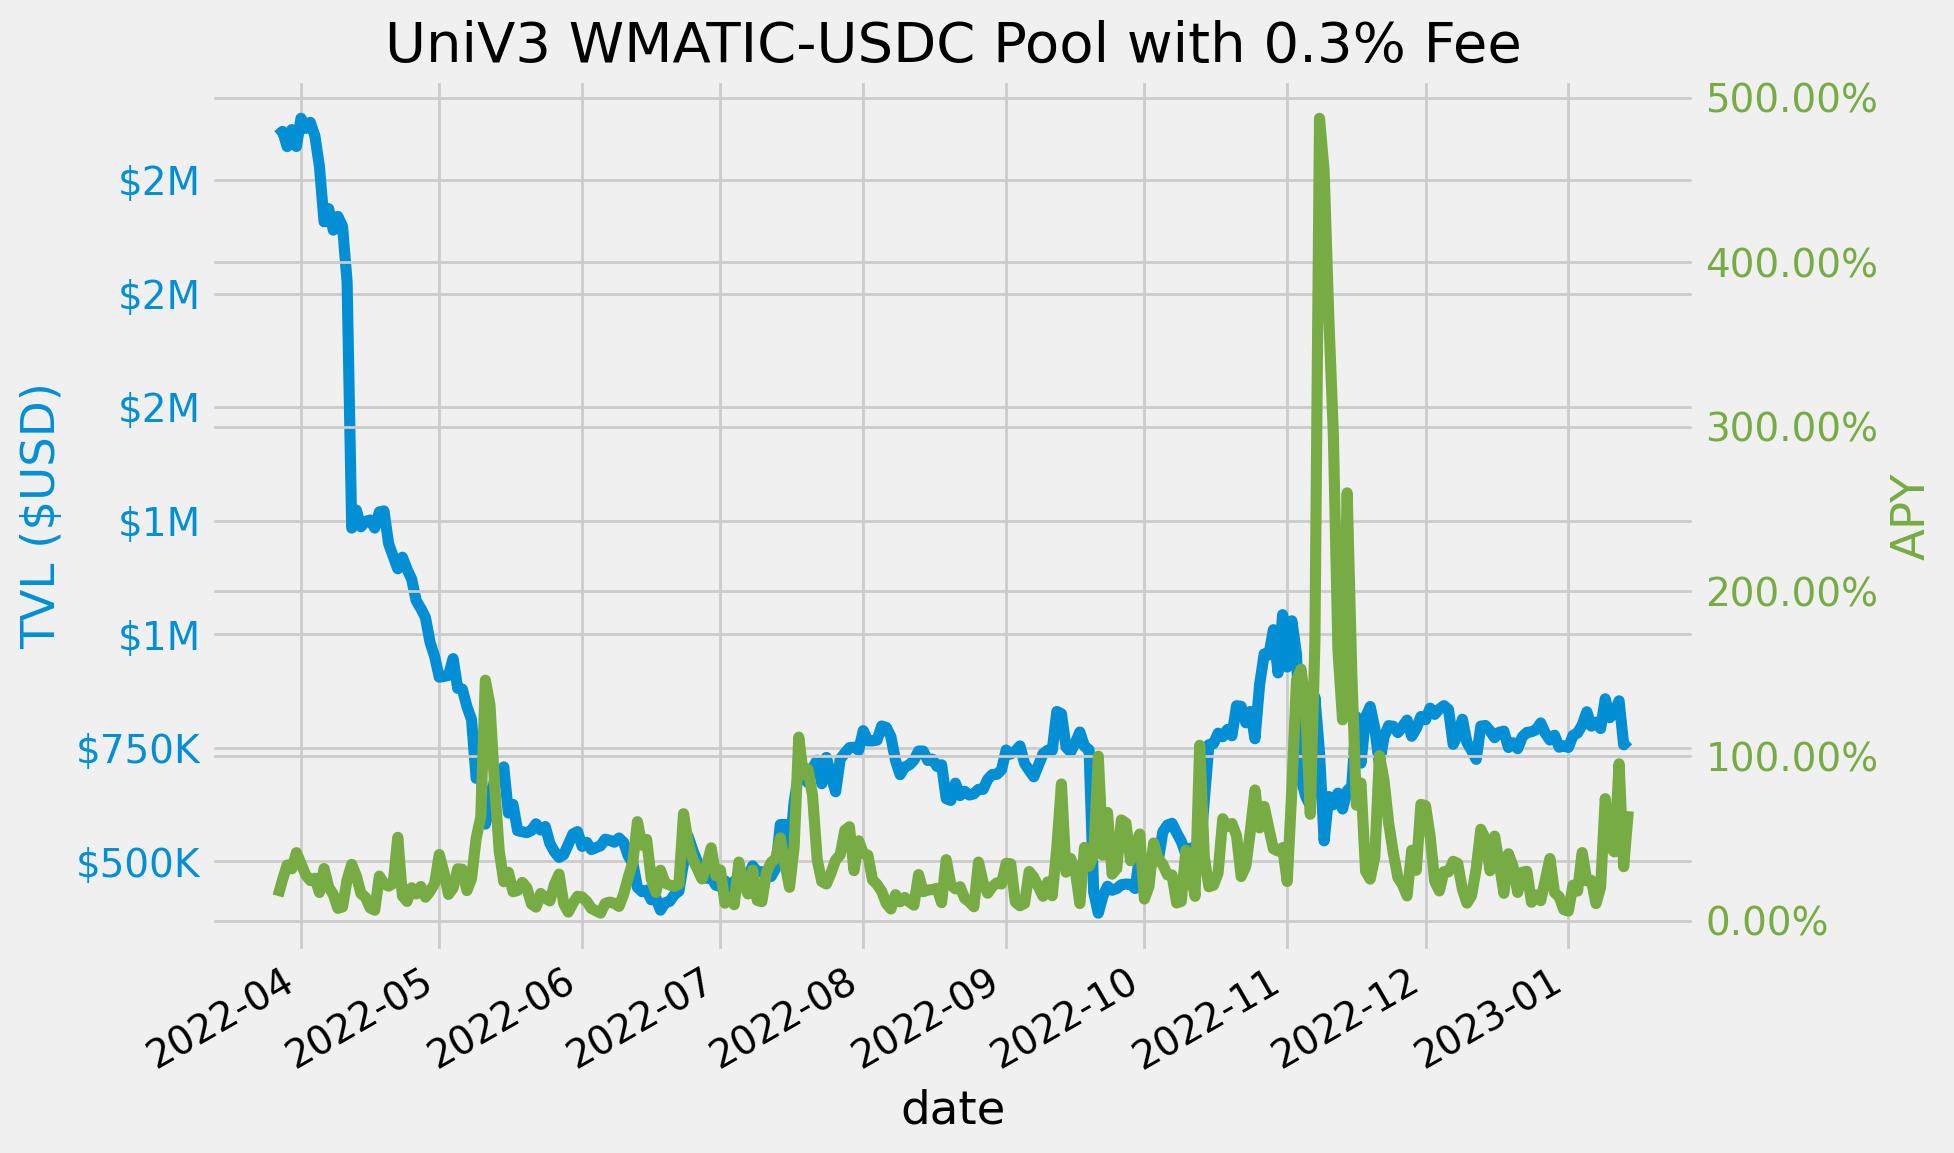

In [16]:
plot_tvl_apy(df03, title='UniV3 WMATIC-USDC Pool with 0.3% Fee')
plt.savefig(os.path.join(png_dir, 'UniV3 WMATIC-USDC Pool with 0.3% Fee.png'), dpi=300)

Similarly, the TVL of 30bp-pool has been going sideways since Dec 2022 and the yield is on the rise. 

In [17]:
# how many days in the past the 0.05%-fee-pool has APY > the 0.3%-fee-pool?
dat = pd.merge(df005, df03, left_index=True, right_index=True)
dat.columns = ['TVL005', 'APY005', 'TVL03', 'APY03']
(dat.APY005 > dat.APY03).sum()

236

In [18]:
(dat.APY005 > dat.APY03).sum() / len(dat)

0.8082191780821918